In [27]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
from tensorflow.keras.layers import Layer

import tqdm
%matplotlib inline

In [28]:
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='/home/natanco-brain/projects/fraunhofer/fraunhofer_backend/models/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

<Functional name=vgg19, built=True>


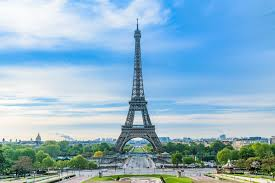

In [29]:
content_image = Image.open("../media/content.jpeg")
content_image

In [30]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    
    m, n_H, n_W, n_C = a_G.shape.as_list()

    
    a_C_unrolled = tf.transpose(tf.reshape(a_C, shape=[m, -1, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, shape=[m, -1, n_C]))
    
    J_content =  (1 / (4 * n_H * n_W * n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    
    
    return J_content

In [31]:
a_C = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)

J_content = compute_content_cost([a_C], [a_G])
J_content_0 = compute_content_cost([a_C], [a_C])

print("J_content = " + str(J_content))

ll = tf.keras.layers.Dense(8, activation='relu', input_shape=(4, 4, 3))
model_tmp = tf.keras.models.Sequential([ll])

input_data = tf.random.normal([1, 4, 4, 3])
output_data = model_tmp(input_data)

J_content_model = compute_content_cost([output_data], [output_data])
print("J_content (model output) =", J_content_model)

J_content = tf.Tensor(8.284592, shape=(), dtype=float32)
J_content (model output) = tf.Tensor(0.0, shape=(), dtype=float32)


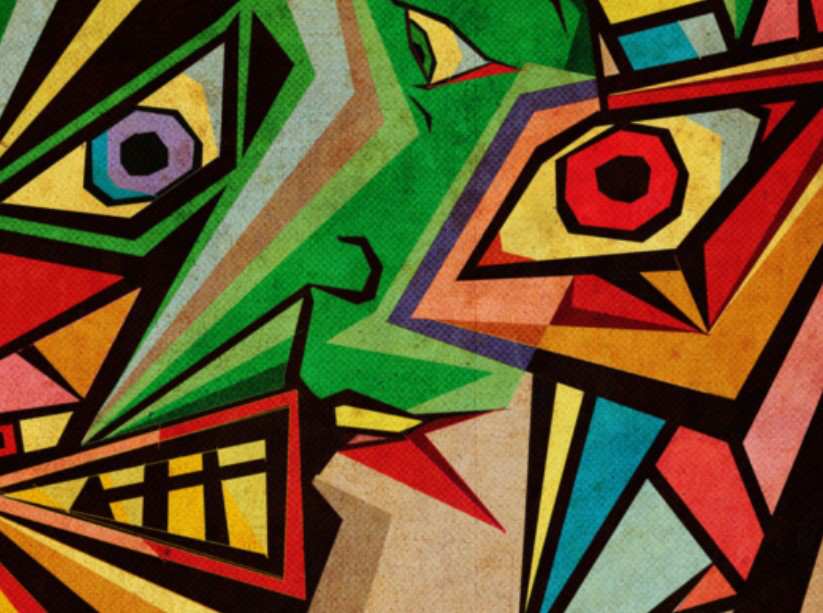

In [32]:
example = Image.open("../media/style.jpeg")
example

In [33]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    
    GA = tf.matmul(A, A, transpose_b=True)
    

    return GA

In [34]:
A = tf.random.normal([3, 2 * 1], mean=1, stddev=4)
GA = gram_matrix(A)

print("GA = \n" + str(GA))


GA = 
tf.Tensor(
[[25.286419  8.864405 21.251131]
 [ 8.864405  8.31359  16.385296]
 [21.251131 16.385296 33.196316]], shape=(3, 3), dtype=float32)


In [35]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    m, n_H, n_W, n_C = a_G.shape
    
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    J_style_layer = (1 / (4 * n_C **2 * (n_H * n_W) **2)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
    
    
    return J_style_layer


In [36]:
a_S = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 4, 4, 3], mean=1, stddev=4)
J_style_layer_GG = compute_layer_style_cost(a_G, a_G)
J_style_layer_SG = compute_layer_style_cost(a_S, a_G)


print("J_style_layer = " + str(J_style_layer_SG))

ll = tf.keras.layers.Dense(8, activation='relu', input_shape=(4, 4, 3))
model_tmp = tf.keras.models.Sequential()
model_tmp.add(ll)

class StyleCostLayer(Layer):
    def call(self, inputs):
        return compute_layer_style_cost(inputs, inputs)

J_style_layer = tf.Tensor(10.575836, shape=(), dtype=float32)


In [37]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [38]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    J_style = 0

    a_S = style_image_output[:-1]

    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        J_style += weight[1] * J_style_layer

    return J_style


In [39]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha * J_content + beta * J_style
    

    return J

In [40]:
J_content = 0.2    
J_style = 0.8
J = total_cost(J_content, J_style)

print("J = " + str(total_cost(np.random.uniform(0, 1), np.random.uniform(0, 1))))


J = tf.Tensor(47.491825, shape=(), dtype=float32)


In [41]:
content_image = np.array(Image.open("../media/content.jpeg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


(1, 400, 400, 3)


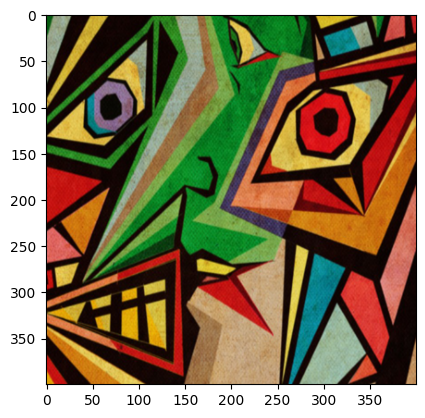

In [42]:
style_image =  np.array(Image.open("../media/style.jpeg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

(1, 400, 400, 3)


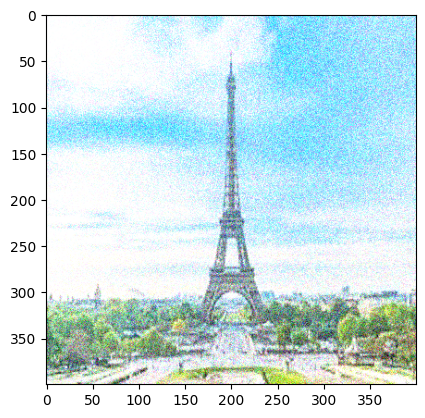

In [43]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), 0, 0.5)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [44]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model



In [45]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [46]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image) 

/home/natanco-brain/miniconda/envs/fraunhofer/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_26']
Received: inputs=Tensor(shape=(1, 400, 400, 3))
  warnings.warn(msg)


In [47]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input.
a_G = vgg_model_outputs(generated_image)

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

print(J_content)

tf.Tensor(0.003983056, shape=(), dtype=float32)


In [48]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

# Compute the style cost
J_style = compute_style_cost(a_S, a_G)
print(J_style)

tf.Tensor(1424.3712, shape=(), dtype=float32)


In [49]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)


In [50]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        a_G = vgg_model_outputs(generated_image)
        J_style = compute_style_cost(a_S, a_G)
        J_content = compute_content_cost(a_C, a_G)
        
        J = total_cost(J_content, J_style)  
        
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))

    return J

In [51]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))

J1 = train_step(generated_image)
print(J1)

J2 = train_step(generated_image)
print(J2)


tf.Tensor(48067.58, shape=(), dtype=float32)
tf.Tensor(39674.363, shape=(), dtype=float32)


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0


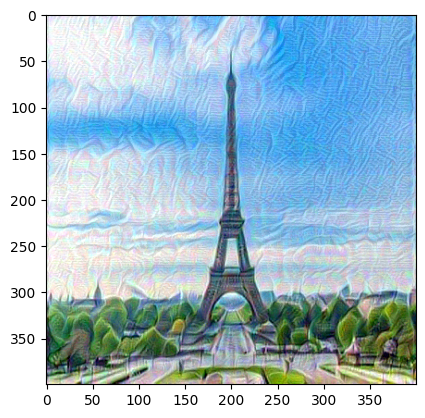

Training Progress:  10%|█         | 10/100 [00:11<01:46,  1.18s/it]

Epoch 10


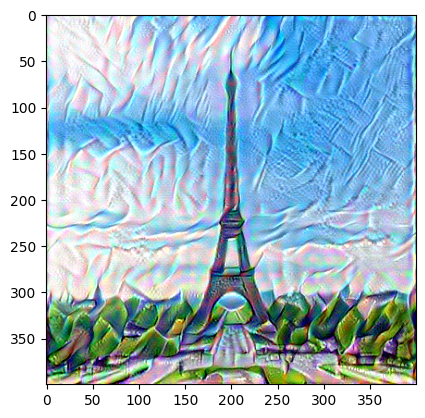

Training Progress:  20%|██        | 20/100 [00:22<01:27,  1.09s/it]

Epoch 20


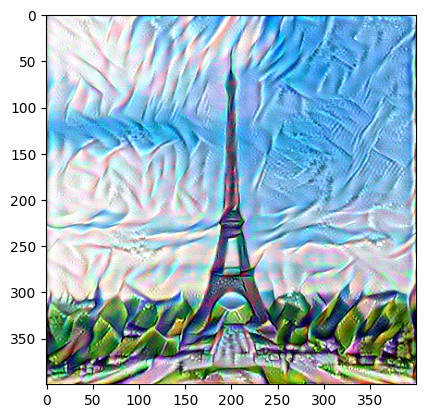

Training Progress:  30%|███       | 30/100 [00:33<01:18,  1.12s/it]

Epoch 30


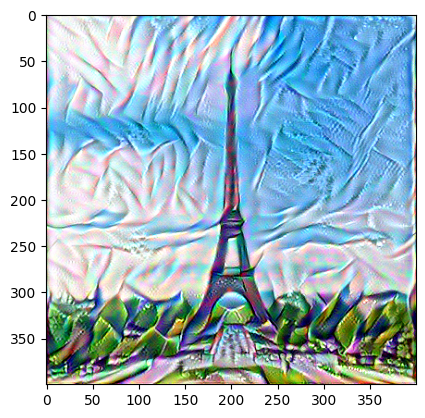

Training Progress:  40%|████      | 40/100 [00:45<01:09,  1.15s/it]

Epoch 40


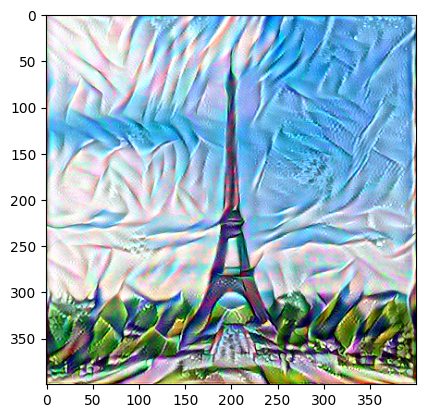

Training Progress:  50%|█████     | 50/100 [00:56<00:55,  1.10s/it]

Epoch 50


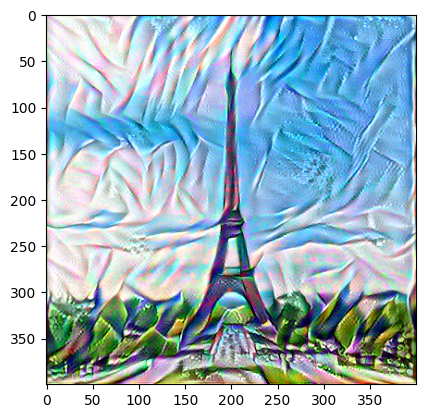

Training Progress:  60%|██████    | 60/100 [01:07<00:43,  1.08s/it]

Epoch 60


Training Progress:  70%|███████   | 70/100 [01:18<00:32,  1.07s/it]

Epoch 70


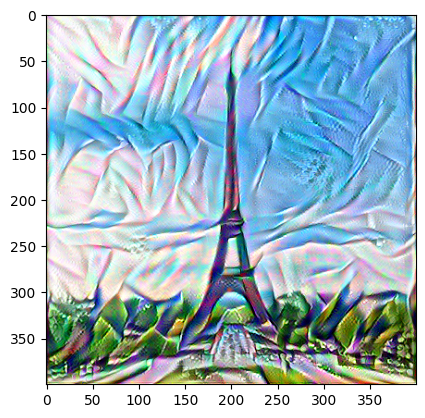

Training Progress:  80%|████████  | 80/100 [01:29<00:21,  1.09s/it]

Epoch 80


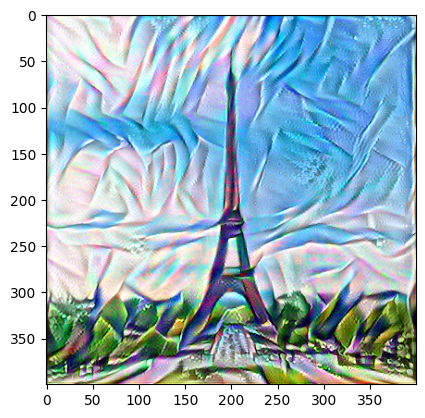

Training Progress:  90%|█████████ | 90/100 [01:40<00:10,  1.08s/it]

Epoch 90


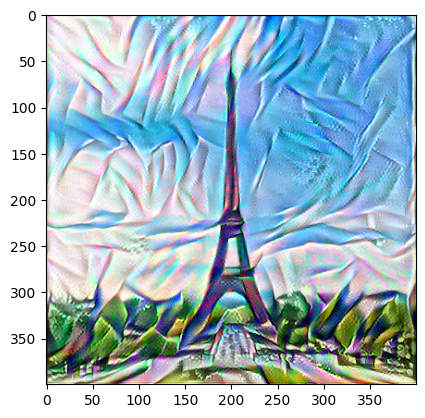

Training Progress: 100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


In [52]:
epochs = 100
for i in tqdm.tqdm(range(epochs), desc="Training Progress"):
    train_step(generated_image)
    
    if i % 10 == 0:
        print(f"Epoch {i}")
        
    if i % 10 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"../media/output/image_{i}.jpg")
        plt.show()